In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.mnist import MNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
import time
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 64
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return logits
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale
    
class SoftmaxLoss(nn.Module):
    def __init__(self, num_classes, embedding_size):
        """
        Regular softmax loss (1 fc layer without bias + CrossEntropyLoss)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        logits = F.linear(embeddings, self.W)
        return nn.CrossEntropyLoss()(logits, labels)

In [5]:
class Embedder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained = False)
        self.dropout = nn.Dropout(0.5)
        
        self.classifier = nn.Linear(1000, embedding_size)

    def forward(self, images):
        outputs = self.model(images)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

In [6]:
embedding_size = 512
max_epochs = 100


embedder = Embedder(embedding_size=embedding_size).to(device)
arcface = ArcFaceLoss(num_classes=10, embedding_size=embedding_size,margin=0.3, scale=30.0).to(device)

optimizer = optim.Adam(embedder.parameters(), lr=1e-3 ) 
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.9)


start = time.time()
for epoch in range(max_epochs):
    e_time = time.time()
    for i, (images, labels) in enumerate(trainloader):
        embedder.train()
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        embeddings = embedder(images)
        
        logits = arcface(embeddings, labels)
        loss = criterion(logits, labels)
        loss.backward() 
        optimizer.step() 
        
        if (i+1) % 64 == 0:
              print(f'Epoch: {epoch} - Batch: {i*batch_size} - Loss: {loss:.6f} - Time:{time.time() - e_time}')

/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ielab/anaconda3/envs/arcface/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: 0 - Batch: 4032 - Loss: 10.005152 - Time:2.0310328006744385
Epoch: 0 - Batch: 8128 - Loss: 9.494844 - Time:2.742605686187744
Epoch: 0 - Batch: 12224 - Loss: 8.905934 - Time:3.453153371810913
Epoch: 0 - Batch: 16320 - Loss: 9.513879 - Time:4.163595199584961
Epoch: 0 - Batch: 20416 - Loss: 8.638481 - Time:4.873561859130859
Epoch: 0 - Batch: 24512 - Loss: 7.569384 - Time:5.584991931915283
Epoch: 0 - Batch: 28608 - Loss: 9.562597 - Time:6.296658515930176
Epoch: 0 - Batch: 32704 - Loss: 8.922046 - Time:7.0075109004974365
Epoch: 0 - Batch: 36800 - Loss: 7.724346 - Time:7.717652082443237
Epoch: 0 - Batch: 40896 - Loss: 7.866495 - Time:8.426944255828857
Epoch: 0 - Batch: 44992 - Loss: 6.712405 - Time:9.136479377746582
Epoch: 0 - Batch: 49088 - Loss: 6.764729 - Time:9.84632921218872
Epoch: 1 - Batch: 4032 - Loss: 7.310117 - Time:0.8320446014404297
Epoch: 1 - Batch: 8128 - Loss: 7.212820 - Time:1.5441563129425049
Epoch: 1 - Batch: 12224 - Loss: 8.476420 - Time:2.255873203277588
Epoch: 1 -

Epoch: 10 - Batch: 20416 - Loss: 2.670723 - Time:3.70060658454895
Epoch: 10 - Batch: 24512 - Loss: 2.126069 - Time:4.41195821762085
Epoch: 10 - Batch: 28608 - Loss: 2.786456 - Time:5.123305797576904
Epoch: 10 - Batch: 32704 - Loss: 3.135288 - Time:5.83512282371521
Epoch: 10 - Batch: 36800 - Loss: 2.590205 - Time:6.546896457672119
Epoch: 10 - Batch: 40896 - Loss: 2.888477 - Time:7.256868839263916
Epoch: 10 - Batch: 44992 - Loss: 3.475722 - Time:7.967651128768921
Epoch: 10 - Batch: 49088 - Loss: 3.311076 - Time:8.679227352142334
Epoch: 11 - Batch: 4032 - Loss: 2.549014 - Time:0.8461208343505859
Epoch: 11 - Batch: 8128 - Loss: 2.433226 - Time:1.5581169128417969
Epoch: 11 - Batch: 12224 - Loss: 2.914897 - Time:2.270368814468384
Epoch: 11 - Batch: 16320 - Loss: 1.624508 - Time:2.9823007583618164
Epoch: 11 - Batch: 20416 - Loss: 2.187978 - Time:3.6940853595733643
Epoch: 11 - Batch: 24512 - Loss: 2.580563 - Time:4.405419588088989
Epoch: 11 - Batch: 28608 - Loss: 2.198194 - Time:5.116954326629

Epoch: 20 - Batch: 32704 - Loss: 1.027437 - Time:5.806713819503784
Epoch: 20 - Batch: 36800 - Loss: 1.806461 - Time:6.5179173946380615
Epoch: 20 - Batch: 40896 - Loss: 1.996335 - Time:7.228177547454834
Epoch: 20 - Batch: 44992 - Loss: 1.048521 - Time:7.939526557922363
Epoch: 20 - Batch: 49088 - Loss: 1.522324 - Time:8.650148630142212
Epoch: 21 - Batch: 4032 - Loss: 1.043986 - Time:0.8302552700042725
Epoch: 21 - Batch: 8128 - Loss: 0.211357 - Time:1.5434894561767578
Epoch: 21 - Batch: 12224 - Loss: 1.368077 - Time:2.255744695663452
Epoch: 21 - Batch: 16320 - Loss: 1.962908 - Time:2.968143939971924
Epoch: 21 - Batch: 20416 - Loss: 1.023940 - Time:3.680481195449829
Epoch: 21 - Batch: 24512 - Loss: 0.712596 - Time:4.392650127410889
Epoch: 21 - Batch: 28608 - Loss: 1.537759 - Time:5.104349374771118
Epoch: 21 - Batch: 32704 - Loss: 0.358686 - Time:5.816159963607788
Epoch: 21 - Batch: 36800 - Loss: 1.620408 - Time:6.52753472328186
Epoch: 21 - Batch: 40896 - Loss: 1.114617 - Time:7.23771739006

Epoch: 30 - Batch: 44992 - Loss: 0.992311 - Time:7.961089134216309
Epoch: 30 - Batch: 49088 - Loss: 1.380397 - Time:8.670819520950317
Epoch: 31 - Batch: 4032 - Loss: 0.538855 - Time:0.8656630516052246
Epoch: 31 - Batch: 8128 - Loss: 0.066844 - Time:1.577690601348877
Epoch: 31 - Batch: 12224 - Loss: 0.384281 - Time:2.2899718284606934
Epoch: 31 - Batch: 16320 - Loss: 0.591817 - Time:3.001339912414551
Epoch: 31 - Batch: 20416 - Loss: 0.206663 - Time:3.7118735313415527
Epoch: 31 - Batch: 24512 - Loss: 0.261428 - Time:4.421582221984863
Epoch: 31 - Batch: 28608 - Loss: 0.948182 - Time:5.131262540817261
Epoch: 31 - Batch: 32704 - Loss: 0.520930 - Time:5.841500282287598
Epoch: 31 - Batch: 36800 - Loss: 0.069069 - Time:6.551678657531738
Epoch: 31 - Batch: 40896 - Loss: 0.017251 - Time:7.261791467666626
Epoch: 31 - Batch: 44992 - Loss: 0.423967 - Time:7.972002983093262
Epoch: 31 - Batch: 49088 - Loss: 0.462109 - Time:8.6817626953125
Epoch: 32 - Batch: 4032 - Loss: 0.401495 - Time:0.8426544666290

Epoch: 41 - Batch: 8128 - Loss: 0.877055 - Time:1.5634377002716064
Epoch: 41 - Batch: 12224 - Loss: 0.699263 - Time:2.2736659049987793
Epoch: 41 - Batch: 16320 - Loss: 0.790320 - Time:2.98388671875
Epoch: 41 - Batch: 20416 - Loss: 0.011569 - Time:3.694103717803955
Epoch: 41 - Batch: 24512 - Loss: 1.210768 - Time:4.404245615005493
Epoch: 41 - Batch: 28608 - Loss: 0.409571 - Time:5.114427804946899
Epoch: 41 - Batch: 32704 - Loss: 0.237858 - Time:5.824406862258911
Epoch: 41 - Batch: 36800 - Loss: 0.509238 - Time:6.534497261047363
Epoch: 41 - Batch: 40896 - Loss: 0.778678 - Time:7.244525671005249
Epoch: 41 - Batch: 44992 - Loss: 0.003037 - Time:7.954087734222412
Epoch: 41 - Batch: 49088 - Loss: 0.464525 - Time:8.663963794708252
Epoch: 42 - Batch: 4032 - Loss: 0.513930 - Time:0.8532347679138184
Epoch: 42 - Batch: 8128 - Loss: 0.585078 - Time:1.5650768280029297
Epoch: 42 - Batch: 12224 - Loss: 0.200271 - Time:2.2762112617492676
Epoch: 42 - Batch: 16320 - Loss: 0.278348 - Time:2.9876892566680

Epoch: 51 - Batch: 20416 - Loss: 0.345204 - Time:3.7025094032287598
Epoch: 51 - Batch: 24512 - Loss: 0.341834 - Time:4.413179636001587
Epoch: 51 - Batch: 28608 - Loss: 0.368896 - Time:5.123427152633667
Epoch: 51 - Batch: 32704 - Loss: 0.530736 - Time:5.8338751792907715
Epoch: 51 - Batch: 36800 - Loss: 0.013531 - Time:6.5440027713775635
Epoch: 51 - Batch: 40896 - Loss: 0.326451 - Time:7.254333734512329
Epoch: 51 - Batch: 44992 - Loss: 0.001799 - Time:7.9642250537872314
Epoch: 51 - Batch: 49088 - Loss: 0.109298 - Time:8.674174785614014
Epoch: 52 - Batch: 4032 - Loss: 0.302212 - Time:0.8310983180999756
Epoch: 52 - Batch: 8128 - Loss: 0.434226 - Time:1.5431361198425293
Epoch: 52 - Batch: 12224 - Loss: 0.381302 - Time:2.2544374465942383
Epoch: 52 - Batch: 16320 - Loss: 0.149607 - Time:2.9651379585266113
Epoch: 52 - Batch: 20416 - Loss: 0.571805 - Time:3.6770262718200684
Epoch: 52 - Batch: 24512 - Loss: 0.001697 - Time:4.387262582778931
Epoch: 52 - Batch: 28608 - Loss: 0.663579 - Time:5.0970

Epoch: 61 - Batch: 32704 - Loss: 0.004871 - Time:5.814043998718262
Epoch: 61 - Batch: 36800 - Loss: 0.000370 - Time:6.5243401527404785
Epoch: 61 - Batch: 40896 - Loss: 0.089396 - Time:7.2346343994140625
Epoch: 61 - Batch: 44992 - Loss: 0.000216 - Time:7.944894313812256
Epoch: 61 - Batch: 49088 - Loss: 0.226769 - Time:8.654737949371338
Epoch: 62 - Batch: 4032 - Loss: 0.000139 - Time:0.8474433422088623
Epoch: 62 - Batch: 8128 - Loss: 0.000882 - Time:1.5605039596557617
Epoch: 62 - Batch: 12224 - Loss: 0.000808 - Time:2.272918462753296
Epoch: 62 - Batch: 16320 - Loss: 0.235552 - Time:2.985098361968994
Epoch: 62 - Batch: 20416 - Loss: 0.263645 - Time:3.695509433746338
Epoch: 62 - Batch: 24512 - Loss: 0.312214 - Time:4.405433654785156
Epoch: 62 - Batch: 28608 - Loss: 0.214240 - Time:5.11562967300415
Epoch: 62 - Batch: 32704 - Loss: 0.132447 - Time:5.826023101806641
Epoch: 62 - Batch: 36800 - Loss: 0.024363 - Time:6.536344051361084
Epoch: 62 - Batch: 40896 - Loss: 0.355472 - Time:7.2481038570

Epoch: 71 - Batch: 44992 - Loss: 0.000908 - Time:7.942273378372192
Epoch: 71 - Batch: 49088 - Loss: 0.037936 - Time:8.652028799057007
Epoch: 72 - Batch: 4032 - Loss: 0.195263 - Time:0.8397154808044434
Epoch: 72 - Batch: 8128 - Loss: 0.101751 - Time:1.5523948669433594
Epoch: 72 - Batch: 12224 - Loss: 0.164797 - Time:2.264617919921875
Epoch: 72 - Batch: 16320 - Loss: 0.000048 - Time:2.977228879928589
Epoch: 72 - Batch: 20416 - Loss: 0.031283 - Time:3.6891913414001465
Epoch: 72 - Batch: 24512 - Loss: 0.128492 - Time:4.400596380233765
Epoch: 72 - Batch: 28608 - Loss: 0.029081 - Time:5.112565040588379
Epoch: 72 - Batch: 32704 - Loss: 0.000907 - Time:5.8234782218933105
Epoch: 72 - Batch: 36800 - Loss: 0.404728 - Time:6.53406548500061
Epoch: 72 - Batch: 40896 - Loss: 0.009643 - Time:7.244574546813965
Epoch: 72 - Batch: 44992 - Loss: 0.020934 - Time:7.954453706741333
Epoch: 72 - Batch: 49088 - Loss: 0.033667 - Time:8.665283441543579
Epoch: 73 - Batch: 4032 - Loss: 0.264397 - Time:0.83382987976

Epoch: 82 - Batch: 8128 - Loss: 0.019582 - Time:1.5434620380401611
Epoch: 82 - Batch: 12224 - Loss: 0.379178 - Time:2.2544209957122803
Epoch: 82 - Batch: 16320 - Loss: 0.000126 - Time:2.9646692276000977
Epoch: 82 - Batch: 20416 - Loss: 0.012026 - Time:3.674976110458374
Epoch: 82 - Batch: 24512 - Loss: 0.020113 - Time:4.385481834411621
Epoch: 82 - Batch: 28608 - Loss: 0.000059 - Time:5.096074342727661
Epoch: 82 - Batch: 32704 - Loss: 0.111715 - Time:5.806262969970703
Epoch: 82 - Batch: 36800 - Loss: 0.000387 - Time:6.516433477401733
Epoch: 82 - Batch: 40896 - Loss: 0.476239 - Time:7.227618217468262
Epoch: 82 - Batch: 44992 - Loss: 0.560797 - Time:7.938583612442017
Epoch: 82 - Batch: 49088 - Loss: 0.016387 - Time:8.649085283279419
Epoch: 83 - Batch: 4032 - Loss: 0.000234 - Time:0.8379864692687988
Epoch: 83 - Batch: 8128 - Loss: 0.187133 - Time:1.5508215427398682
Epoch: 83 - Batch: 12224 - Loss: 0.260145 - Time:2.263467788696289
Epoch: 83 - Batch: 16320 - Loss: 0.012114 - Time:2.975804090

Epoch: 92 - Batch: 20416 - Loss: 0.000137 - Time:3.679042339324951
Epoch: 92 - Batch: 24512 - Loss: 0.212718 - Time:4.38939356803894
Epoch: 92 - Batch: 28608 - Loss: 0.150928 - Time:5.099616527557373
Epoch: 92 - Batch: 32704 - Loss: 0.042906 - Time:5.809756755828857
Epoch: 92 - Batch: 36800 - Loss: 0.130423 - Time:6.519630193710327
Epoch: 92 - Batch: 40896 - Loss: 0.050552 - Time:7.229262590408325
Epoch: 92 - Batch: 44992 - Loss: 0.751012 - Time:7.939157485961914
Epoch: 92 - Batch: 49088 - Loss: 0.289291 - Time:8.648610591888428
Epoch: 93 - Batch: 4032 - Loss: 0.005367 - Time:0.832998514175415
Epoch: 93 - Batch: 8128 - Loss: 0.000638 - Time:1.5430519580841064
Epoch: 93 - Batch: 12224 - Loss: 0.715608 - Time:2.252671718597412
Epoch: 93 - Batch: 16320 - Loss: 0.001994 - Time:2.962562322616577
Epoch: 93 - Batch: 20416 - Loss: 0.000122 - Time:3.672585964202881
Epoch: 93 - Batch: 24512 - Loss: 0.000361 - Time:4.381983995437622
Epoch: 93 - Batch: 28608 - Loss: 0.000153 - Time:5.0911676883697

In [7]:
import plotly.express as px

In [8]:
import pandas as pd

In [9]:
train_results = []
train_labels = []
df = pd.DataFrame(columns=['x', 'y', 'z', 'label'])

embedder.eval()
with torch.no_grad():
    for img, label in trainloader:
        img = img.cuda()
        train_results.append(embedder(img).cpu().detach().numpy())
        train_labels.append(label)
        
train_results = np.concatenate(train_results)
train_labels = np.concatenate(train_labels)

for label in np.unique(train_labels):        
    tmp = train_results[train_labels==label]
    dict_ = {'x':tmp[:,0], 'y':tmp[:,1], 'z':tmp[:,2], 'label': label}
    df.loc[label]=[tmp[:,0], tmp[:,1], tmp[:,2], label]

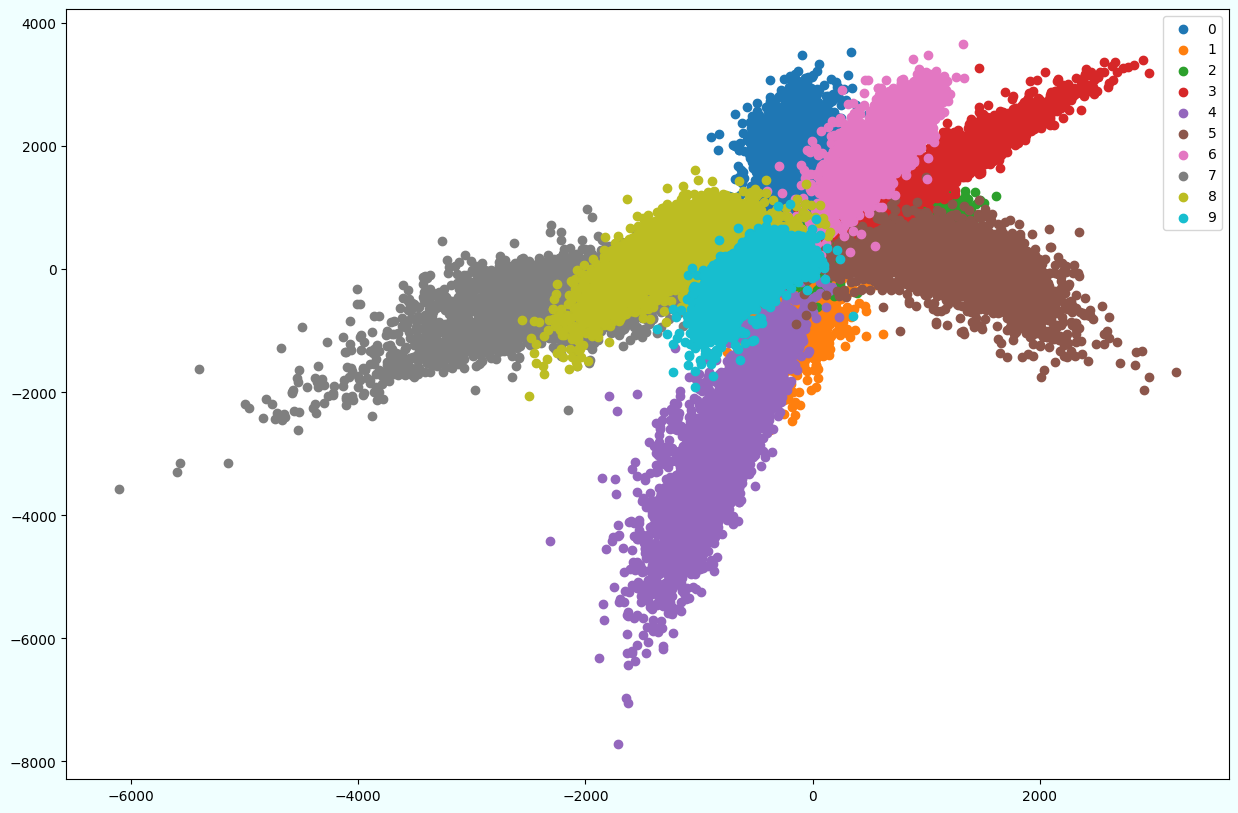

In [10]:
train_results = []
train_labels = []

embedder.eval()
with torch.no_grad():
  for img, label in trainloader:
    img = img.cuda()
    train_results.append(embedder(img).cpu().detach().numpy())
    train_labels.append(label)
        
train_results = np.concatenate(train_results)
train_labels = np.concatenate(train_labels)

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(train_labels):        
  tmp = train_results[train_labels==label]
  plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

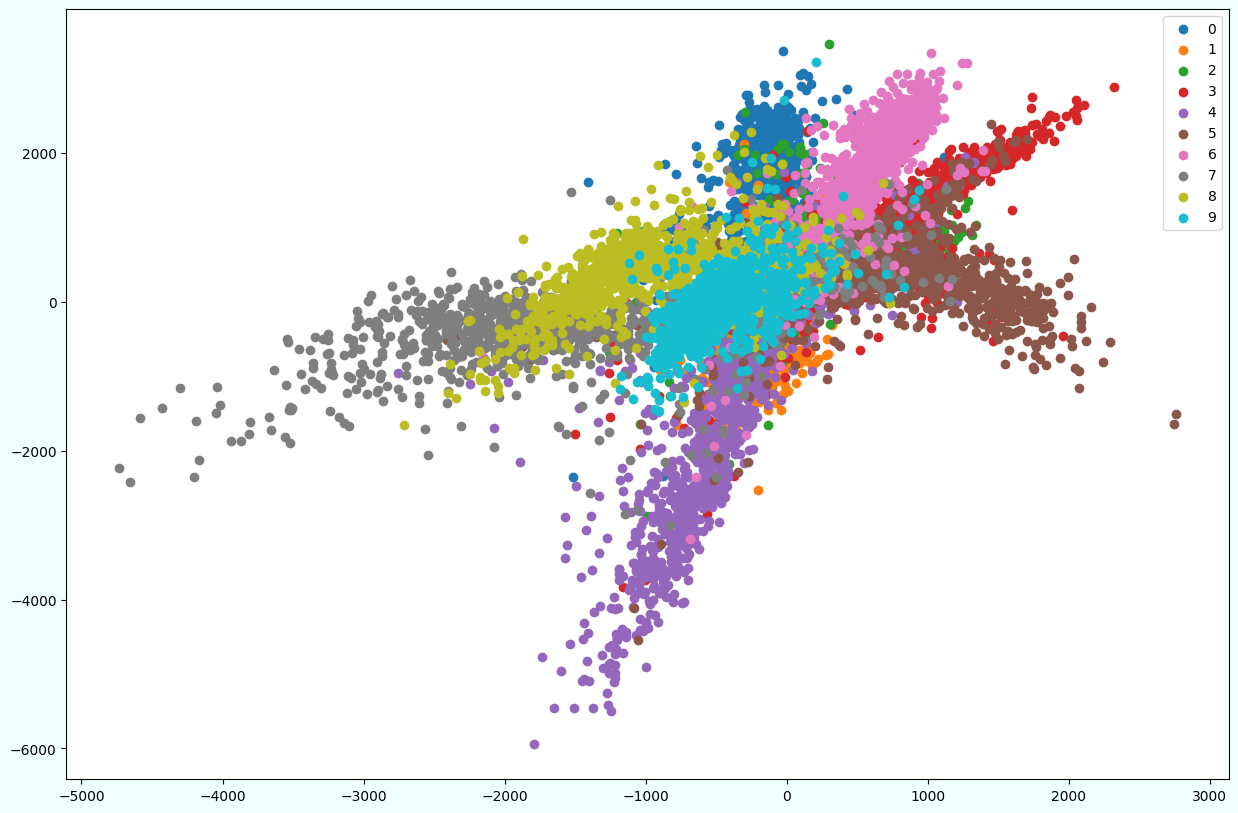

In [11]:
test_results = []
test_labels = []

embedder.eval()
with torch.no_grad():
  for img, label in testloader:
    img = img.cuda()
    test_results.append(embedder(img).cpu().detach().numpy())
    test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)

plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(test_labels):        
  tmp = test_results[test_labels==label]
  plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [14]:
from sklearn.neighbors import KNeighborsClassifier


# kNN 모델 선언
k = 512
model = KNeighborsClassifier(n_neighbors = k)
# 모델 학습
model.fit(train_results, train_labels)

KNeighborsClassifier(n_neighbors=512)

In [15]:
train_pred = model.predict(train_results)
(train_pred == train_labels).mean()

0.99828

In [16]:
test_pred = model.predict(test_results)
(test_pred == test_labels).mean()

0.772